In this notebook, I will be performing some clustering on the COVID-19 trials data available from WHO. Each clinical trial has certain interventions defined as: A process or action that is the focus of a clinical study. Interventions include drugs, medical devices, procedures, vaccines, and other products that are either investigational or already available. Interventions can also include noninvasive approaches, such as education or modifying diet and exercise. 

Clustering the interventions gives us the ability to get a better view of the nature of these clinical trials which further coupled with 'geolocation data' and 'clinical trials to research mapping' can be extremely insightful

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')
#Getting the imports done
import numpy as np 
import pandas as pd 
import os
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import xml.etree.ElementTree as ET

In [244]:
#Reading in our file
df = pd.read_csv("gdrive/My Drive/COVID19.csv")
df.head()

,TrialID,Last Refreshed on,Public title,Scientific title,Acronym,Primary sponsor,Date registration,Date registration3,Export date,Source Register,web address,Recruitment Status,other records,Inclusion agemin,Inclusion agemax,Inclusion gender,Date enrollement,Target size,Study type,Study design,Phase,Countries,Contact Firstname,Contact Lastname,Contact Address,Contact Email,Contact Tel,Contact Affiliation,Inclusion Criteria,Exclusion Criteria,Condition,Intervention,Primary outcome,results date posted,results date completed,results url link,Retrospective flag,Bridging flag truefalse,Bridged type,results yes no
0,NCT04246242,3 February 2020,A Randomized Multicenter Controlled Clinical T...,A Randomized Multicenter Controlled Clinical T...,NaN,Xiangya Hospital of Central South University,27/01/2020,20200127,4/7/2020 10:40:56 AM,ClinicalTrials.gov,https://clinicaltrials.gov/show/NCT04246242,Not recruiting,No,NaN,NaN,All,"January 25, 2020",500,Interventional,Allocation: Randomized. Intervention model: Pa...,Phase 4,NaN,,"Pinhua Pan, Medical PhD",NaN,pinhuapan668@126.com,+86 13574810968,NaN,\r<br> Inclusion Criteria:\r<br>\r<br> ...,NaN,2019 Novel Coronavirus,Drug: Conventional treatment group;Drug: arbid...,mortality,NaN,NaN,NaN,Yes,False,,NaN
1,ChiCTR2000029949,17 February 2020,A Medical Records Based Study for the Effectiv...,A Medical Records Based Study for the Effectiv...,NaN,Emergency Department of Zhongnan hospital of W...,2020-02-16,20200216,4/7/2020 10:40:56 AM,ChiCTR,http://www.chictr.org.cn/showproj.aspx?proj=49181,Not Recruiting,No,18,NaN,Both,2020-02-16,Case series:40;,Observational study,Sequential,Retrospective study,China,"Yan, Zhao",NaN,"169 Donghu Road, Wuchang District, Wuhan, Hube...",doctoryanzhao@whu.edu.cn,+86 13995577963,Emergency Department of Zhongnan hospital of W...,Inclusion criteria: 1. Aged >=18 years; \r<br>...,Exclusion criteria: Absolutely forbidden crite...,Novel Coronavirus Pneumonia (COVID-19),Case series:Extracorporeal Membrane Oxygenation;,inhospital length;inhospital mortality;ECMO tr...,NaN,NaN,NaN,Yes,False,,NaN
2,NCT04245631,17 February 2020,"Development of a Simple, Fast and Portable Rec...","Development of a Simple, Fast and Portable Rec...",NaN,Beijing Ditan Hospital,26/01/2020,20200126,4/7/2020 10:40:56 AM,ClinicalTrials.gov,https://clinicaltrials.gov/show/NCT04245631,Recruiting,No,1 Year,90 Years,All,"January 1, 2020",50,Observational,NaN,NaN,China,; ;,"Yao Xie, Doctor;Yao Xie, Doctor;Yao Xie, Doctor",NaN,;xieyao00120184@sina.com;xieyao00120184@sina.com,;8610-84322200;8610-84322200,"Department of Hepatology, Division 2, Beijing ...",\r<br> Inclusion Criteria:\r<br>\r<br> ...,NaN,New Coronavirus,Diagnostic Test: Recombinase aided amplificati...,Detection specificity is greater than 95%;Dete...,NaN,NaN,NaN,Yes,False,,NaN
3,NCT04252885,17 February 2020,The Efficacy of Lopinavir Plus Ritonavir and A...,"A Randomized, Open-label, Controlled Study of ...",ELACOI,Guangzhou 8th People's Hospital,30/01/2020,20200130,4/7/2020 10:40:56 AM,ClinicalTrials.gov,https://clinicaltrials.gov/show/NCT04252885,Recruiting,No,18 Years,80 Years,All,"January 28, 2020",125,Interventional,Allocation: Randomized. Intervention model: Pa...,Phase 4,China,;,"Yueping Li, MD, Master;Linghua Li, MD, PhD",NaN,lipipi007@163.com;,020- 36052117;,NaN,\r<br> Inclusion Criteria:\r<br>\r<br> ...,NaN,Coronavirus Infections,Drug: Lopinavir and Ritonavir Tablets;Drug: Ar...,The rate of virus inhibition,NaN,NaN,NaN,Yes,False,,NaN
4,NCT04255940,17 February 2020,2019-nCoV Outbreak and Cardiovascular Diseases,Impact of a Novel Coronavirus (2019-nCoV) Outb...,NaN,Qilu Hospital of Shandong University,03/02/2020,20200203,4/7/2020 10:40:56 AM,ClinicalTrials.gov,https://clinicaltrials.gov/show/NCT04255940,Recruiting,No,NaN,NaN,All,"January 20, 2020",12000,Observational,NaN,Phase 4,China,,"Panpan Hao, MD",NaN,panda.how@sdu.edu.cn,86-18560086593,NaN,\r<br> Inclusion Criteria:\r<br>\r<br> ...,NaN,Cardiovascular Death; Major Adverse Cardiovas

While cleaning the columns, I observed that since the data source may be scraped, it consists some junk characters and numbers that distort our results. Moreover, the terms "covid", "coronavirus", "novel" and "ncov" all are often present and add little value to the intervention type

In [0]:
#Cleaning the columns
import re
def cleaner(data):
  data = data.replace('br','')
  data = data.replace('covid','')
  data = data.replace('coronavirus','')
  data = data.replace('ncov','')
  data = data.replace('novel','')
  data = re.sub(r'([^a-zA-Z ]+?)', ' ', data).lower()
  data = re.sub(r"\s\s+"," ",data)
  return data

df = df.dropna(subset=['Intervention'])

In [0]:
#Next step is to prepare a corpus for our TfIdf vectors
def build_corpus(data,col):
  corpus=[]
  for sentence in data[col].iteritems():
    corpus.append(sentence[1].rstrip())
  return corpus



In [0]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(stop_words='english')
from sklearn.preprocessing import normalize
def uniquevals(data):
  l = list(set(data.split(" ")))
  return " ".join(l)
#In this short text matching I dont really care about order of words and don't really intend to capture repetitions.
#Rather I just want to capture some keywords
df['Intervention'] = df['Intervention'].apply(cleaner)
df['Intervention'] = df['Intervention'].apply(uniquevals)
corpus = build_corpus(df,'Intervention')
xvec = tfidf.fit_transform(corpus) 
tf_idf_norm = normalize(xvec)
tf_idf_array = tf_idf_norm.toarray()

Our TF-IDF vector will have a high number of dimensions and can suffer from the curse of dimensionality so we reduce it using PCA

In [0]:
from sklearn.decomposition import PCA
sklearn_pca = PCA(n_components = 2)
pca_vec = sklearn_pca.fit_transform(tf_idf_array)

Next, we observe the SSE vs No of clusters graph to observe an elbow as a possible estimate of the number of clusters

Fit 2 clusters
Fit 4 clusters
Fit 6 clusters
Fit 8 clusters
Fit 10 clusters
Fit 12 clusters
Fit 14 clusters
Fit 16 clusters
Fit 18 clusters
Fit 20 clusters
Fit 22 clusters
Fit 24 clusters
Fit 26 clusters
Fit 28 clusters
Fit 30 clusters


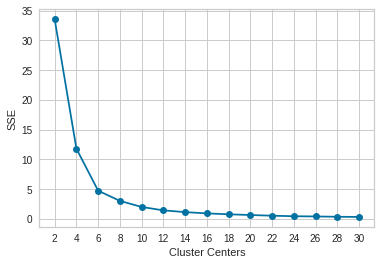

In [249]:
#K Means Clustering on Interventions
#To choose the number of cluster, we use an SSE measure and observe elbows in the graph
from sklearn.cluster import KMeans
def find_optimal_clusters(data, max_k):
    iters = range(2, max_k+1, 2)
    sse = []
    for k in iters:
        sse.append(KMeans(n_clusters=k, random_state=42).fit(data).inertia_)
        print('Fit {} clusters'.format(k))
        
    f, ax = plt.subplots(1, 1)
    ax.plot(iters, sse, marker='o')
    ax.set_xlabel('Cluster Centers')
    ax.set_xticks(iters)
    ax.set_xticklabels(iters)
    ax.set_ylabel('SSE')
    
find_optimal_clusters(pca_vec, 30)

At around 6 clusters, we can observe an "elbow". We shall use this for our K-Means algorithm. In the next step, I will also create a scatter plot to visualize how our K-Means clustering has worked

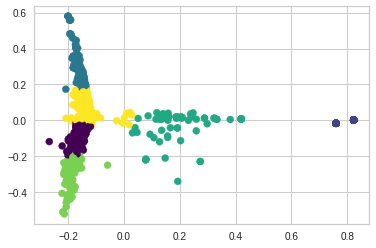

In [250]:
kmeans = KMeans(n_clusters=6)
fitted = kmeans.fit(pca_vec)
prediction = kmeans.predict(pca_vec)
plt.scatter(Y_sklearn[:, 0], Y_sklearn[:, 1],c=prediction, s=50, cmap='viridis')
plt.show()

In [251]:
#Let's add our predicted classes to the dataset and save it
df['class_label'] = prediction
df.head()

,TrialID,Last Refreshed on,Public title,Scientific title,Acronym,Primary sponsor,Date registration,Date registration3,Export date,Source Register,web address,Recruitment Status,other records,Inclusion agemin,Inclusion agemax,Inclusion gender,Date enrollement,Target size,Study type,Study design,Phase,Countries,Contact Firstname,Contact Lastname,Contact Address,Contact Email,Contact Tel,Contact Affiliation,Inclusion Criteria,Exclusion Criteria,Condition,Intervention,Primary outcome,results date posted,results date completed,results url link,Retrospective flag,Bridging flag truefalse,Bridged type,results yes no,class_label
0,NCT04246242,3 February 2020,A Randomized Multicenter Controlled Clinical T...,A Randomized Multicenter Controlled Clinical T...,NaN,Xiangya Hospital of Central South University,27/01/2020,20200127,4/7/2020 10:40:56 AM,ClinicalTrials.gov,https://clinicaltrials.gov/show/NCT04246242,Not recruiting,No,NaN,NaN,All,"January 25, 2020",500,Interventional,Allocation: Randomized. Intervention model: Pa...,Phase 4,NaN,,"Pinhua Pan, Medical PhD",NaN,pinhuapan668@126.com,+86 13574810968,NaN,\r<br> Inclusion Criteria:\r<br>\r<br> ...,NaN,2019 Novel Coronavirus,arbidol mg tid conventional group treatment drug,mortality,NaN,NaN,NaN,Yes,False,,NaN,5
1,ChiCTR2000029949,17 February 2020,A Medical Records Based Study for the Effectiv...,A Medical Records Based Study for the Effectiv...,NaN,Emergency Department of Zhongnan hospital of W...,2020-02-16,20200216,4/7/2020 10:40:56 AM,ChiCTR,http://www.chictr.org.cn/showproj.aspx?proj=49181,Not Recruiting,No,18,NaN,Both,2020-02-16,Case series:40;,Observational study,Sequential,Retrospective study,China,"Yan, Zhao",NaN,"169 Donghu Road, Wuchang District, Wuhan, Hube...",doctoryanzhao@whu.edu.cn,+86 13995577963,Emergency Department of Zhongnan hospital of W...,Inclusion criteria: 1. Aged >=18 years; \r<br>...,Exclusion criteria: Absolutely forbidden crite...,Novel Coronavirus Pneumonia (COVID-19),memane case series extracorporeal oxygenation,inhospital length;inhospital mortality;ECMO tr...,NaN,NaN,NaN,Yes,False,,NaN,3
2,NCT04245631,17 February 2020,"Development of a Simple, Fast and Portable Rec...","Development of a Simple, Fast and Portable Rec...",NaN,Beijing Ditan Hospital,26/01/2020,20200126,4/7/2020 10:40:56 AM,ClinicalTrials.gov,https://clinicaltrials.gov/show/NCT04245631,Recruiting,No,1 Year,90 Years,All,"January 1, 2020",50,Observational,NaN,NaN,China,; ;,"Yao Xie, Doctor;Yao Xie, Doctor;Yao Xie, Doctor",NaN,;xieyao00120184@sina.com;xieyao00120184@sina.com,;8610-84322200;8610-84322200,"Department of Hepatology, Division 2, Beijing ...",\r<br> Inclusion Criteria:\r<br>\r<br> ...,NaN,New Coronavirus,aided diagnostic amplification assay recombina...,Detection specificity is greater than 95%;Dete...,NaN,NaN,NaN,Yes,False,,NaN,5
3,NCT04252885,17 February 2020,The Efficacy of Lopinavir Plus Ritonavir and A...,"A Randomized, Open-label, Controlled Study of ...",ELACOI,Guangzhou 8th People's Hospital,30/01/2020,20200130,4/7/2020 10:40:56 AM,ClinicalTrials.gov,https://clinicaltrials.gov/show/NCT04252885,Recruiting,No,18 Years,80 Years,All,"January 28, 2020",125,Interventional,Allocation: Randomized. Intervention model: Pa...,Phase 4,China,;,"Yueping Li, MD, Master;Linghua Li, MD, PhD",NaN,lipipi007@163.com;,020- 36052117;,NaN,\r<br> Inclusion Criteria:\r<br>\r<br> ...,NaN,Coronavirus Infections,arbidol lopinavir tablets ritonavir and drug,The rate of virus inhibition,NaN,NaN,NaN,Yes,False,,NaN,2
6,ChiCTR2000029953,17 February 2020,Construction and Analysis of Prognostic Predic...,Construction and Analysis of Prognostic Predic...,NaN,Zhongnan Hospital of Wuhan University,2020-02-17,20200217,4/7/2020 10:40:56 AM,ChiCTR,http://www.chictr.org.cn/showproj.aspx?proj=49217,Not Recruiting,No,NaN,NaN,Both,2020-02-01,survival group:200;died:200;,Observational study,Factorial,NaN,China,Yan Zhao,NaN,"169 Donghu Road, Wuchang District, Wuhan, Hube...",doctoryanzhao@whu.edu.cn,+86 13995577963,Emerge

Next, we will visualize the top 5 keywords for every cluster to analyze the clusters formed

In [0]:
def get_top_features_cluster(tf_idf_array, prediction, n_feats):
    labels = np.unique(prediction)
    dfs = []
    for label in labels:
        id_temp = np.where(prediction==label) 
        x_means = np.mean(tf_idf_array[id_temp], axis = 0) 
        sorted_means = np.argsort(x_means)[::-1][:n_feats] 
        features = tfidf.get_feature_names()
        best_features = [(features[i], x_means[i]) for i in sorted_means]
        df_temp = pd.DataFrame(best_features, columns = ['keywords', 'score'])
        dfs.append(df_temp)
    return dfs
dfs = get_top_features_cluster(tf_idf_array, prediction, 5)

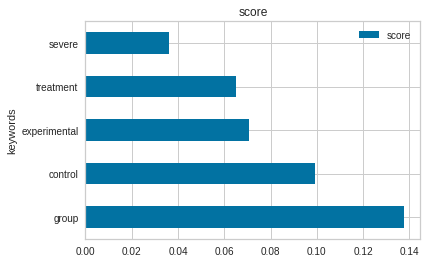

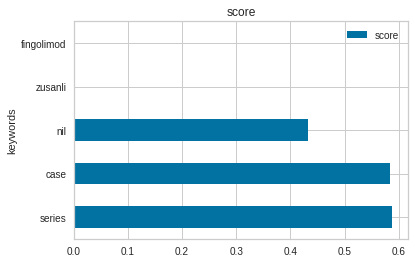

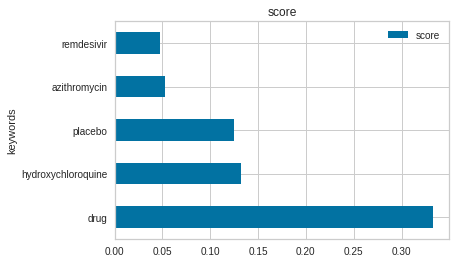

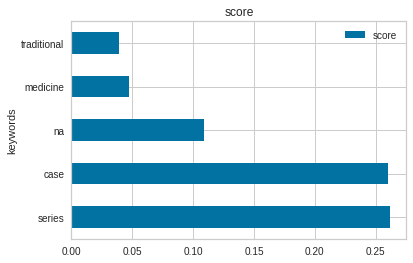

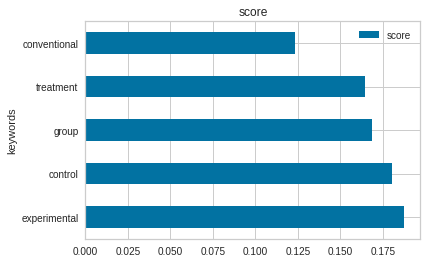

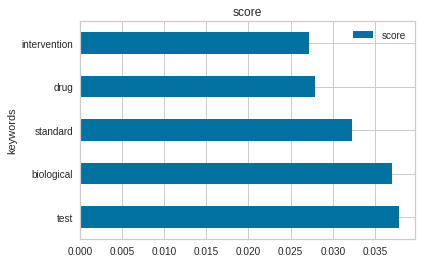

In [255]:
for item in dfs:
  ax = item.plot.barh(subplots=True,x='keywords', y='score')


As can be seen, 6 major cluster categories have been formed with these keywords. Some initial insights can be drawn from these clusters. For instance one cluster focuses on drug based interventions, one on testing techniques and standards, one on traditional medicines, another on case series and so on. Medical domain experts might be able to understand and interpret these